In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE = 640
BATCH_SIZE = 32
Data_path = 'ricedata2'
EPOCHS = 30


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    Data_path,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 5765 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['browon_spot', 'leaf_scaled', 'rice_blast', 'rice_turgro', 'sheath_blight']

In [7]:
len(dataset)

181

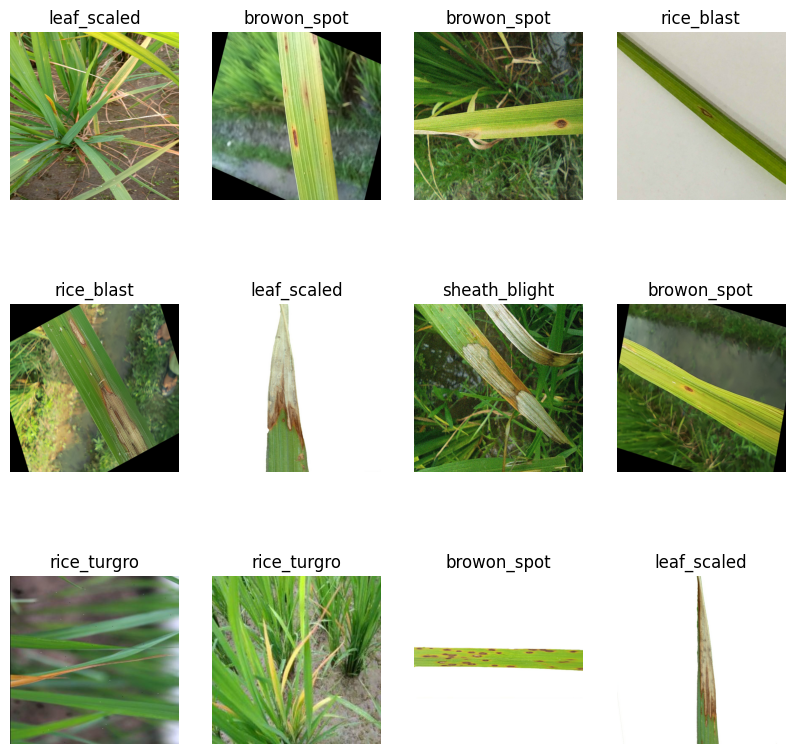

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1) :
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
    

In [11]:
len(dataset)

181

80% ==> traing
20% ==> 10% validation, 10% test

In [12]:
total_size = len(dataset)


train_size = 0.6
num_train = int(total_size * train_size)
train_ds = dataset.take(num_train)


val_size = 0.2
num_val = int(total_size * val_size)


test_ds = dataset.skip(num_train)
val_ds = test_ds.take(num_val)
test_ds = test_ds.skip(num_val)

# ตรวจสอบขนาด
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 108
Validation dataset size: 36
Test dataset size: 37


In [13]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
 
    ds_size = len(list(ds)) 

   
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  

    return train_ds, val_ds, test_ds

In [14]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

108

In [16]:
len(val_ds)

36

In [17]:
len(test_ds)

37

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    
    
])

In [21]:
CHANNELS = 3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)     

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:

model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    

)

Epoch 1/30
108/108 [==============================] - 81s 518ms/step - loss: 3.9781 - accuracy: 0.5813 - val_loss: 7.2625 - val_accuracy: 0.2109
Epoch 2/30
108/108 [==============================] - 40s 374ms/step - loss: 2.5964 - accuracy: 0.6785 - val_loss: 4.2345 - val_accuracy: 0.3177
Epoch 3/30
108/108 [==============================] - 40s 368ms/step - loss: 1.7968 - accuracy: 0.7245 - val_loss: 3.6771 - val_accuracy: 0.2951
Epoch 4/30
108/108 [==============================] - 40s 370ms/step - loss: 1.3186 - accuracy: 0.7468 - val_loss: 2.6144 - val_accuracy: 0.4410
Epoch 5/30
108/108 [==============================] - 41s 381ms/step - loss: 1.0381 - accuracy: 0.7833 - val_loss: 2.3318 - val_accuracy: 0.3481
Epoch 6/30
108/108 [==============================] - 40s 370ms/step - loss: 0.8708 - accuracy: 0.7818 - val_loss: 1.6533 - val_accuracy: 0.5590
Epoch 7/30
108/108 [==============================] - 40s 368ms/step - loss: 0.7841 - accuracy: 0.7977 - val_loss: 0.9276 - val_ac

In [25]:
score = model.evaluate(test_ds)
score

37/37 [==============================] - 15s 46ms/step - loss: 0.6059 - accuracy: 0.8412


[0.6059324741363525, 0.8412162065505981]

In [26]:

model.save("models2.keras")

In [28]:
from keras.models import load_model

modelt = load_model('models2.keras')

In [29]:
modelt.evaluate(test_ds)

37/37 [==============================] - 2s 45ms/step - loss: 0.6059 - accuracy: 0.8412


[0.6059324145317078, 0.8412162065505981]

first image to predict
first images's actual label :  rice_blast
1/1 [==============================] - 0s 33ms/step
rice_blast


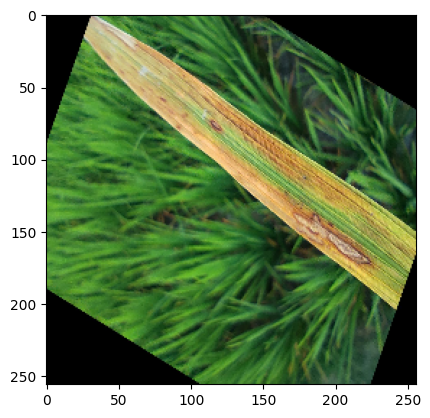

In [38]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first images's actual label : ",class_names[first_label])
    batch_prediction = modelt.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    # แปลงภาพเป็น array และขยายมิติ
    img_array = tf.image.convert_image_dtype(img, dtype=tf.float32)  # แปลงให้เป็น float32
    img_array = tf.expand_dims(img_array, axis=0)  # เพิ่มมิติใหม่ให้กับ batch
    prediction = model.predict(img_array)  # ทำนาย
    predicted_class = np.argmax(prediction)  # หา class ที่มีคะแนนสูงสุด
    confidence = np.max(prediction)  # หา confidence สูงสุด
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


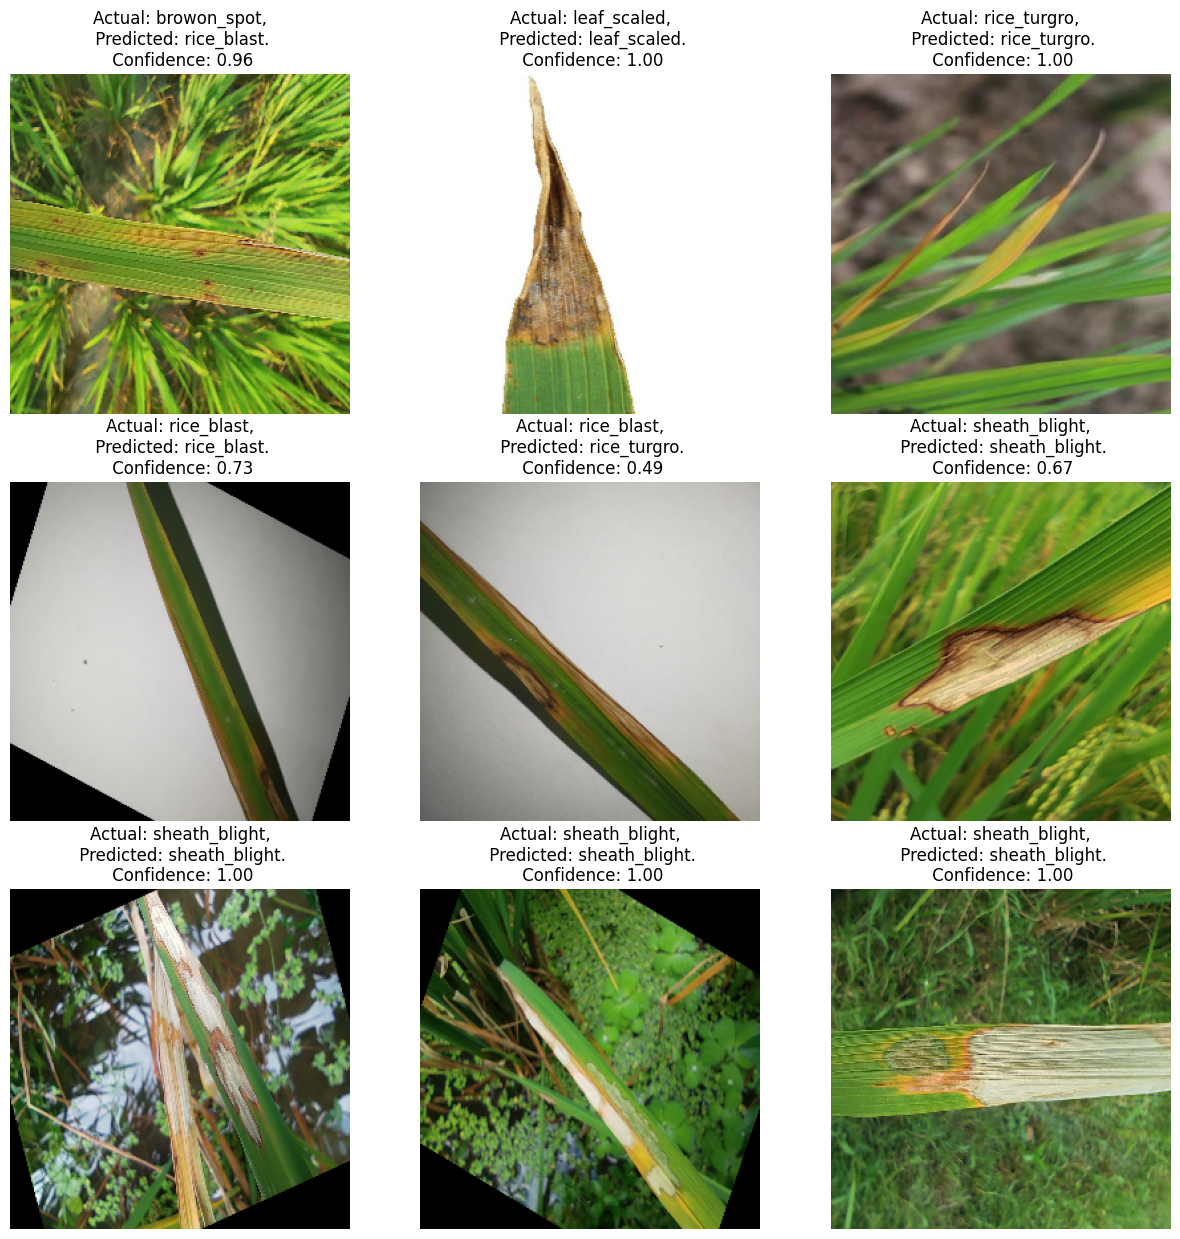

In [40]:
plt.figure(figsize=(15,15))    

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # ทำนายและดึงค่าที่เกี่ยวข้อง
        predicted_class_index, confidence = predict(modelt, images[i].numpy())
        predicted_class = class_names[predicted_class_index]
        
        # ดึงชื่อคลาสจริง
        actual_class_index = labels[i].numpy()
        actual_class = class_names[actual_class_index]
        
        # แสดงชื่อคลาสจริงและคาดการณ์
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}")
        plt.axis("off")

plt.show()

1/1 [==============================] - 0s 17ms/step


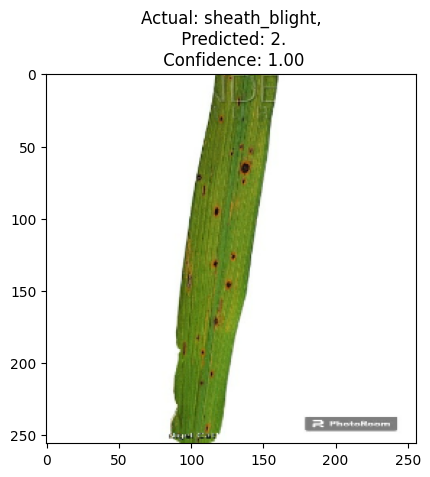

Predicted Class: 2


In [62]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# ขั้นตอนที่ 2: โหลดรูปภาพใหม่ที่ต้องการทดสอบ
img_path = 'bn2e.jpg'
img_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(img_raw, channels=3)
img = tf.image.resize(img, [256, 256]) # ปรับขนาดตามที่โมเดลต้องการ

# ขั้นตอนที่ 3: ปรับขนาดและปรับแต่งรูปภาพให้ตรงกับ input ของโมเดล
img_array = tf.expand_dims(img, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array) # ปรับให้เหมาะสมกับโมเดลที่ใช้

# ขั้นตอนที่ 4: ทำนายผลลัพธ์จากโมเดล
predictions = modelt.predict(img_array)
predicted_class = np.argmax(predictions[0])

# ขั้นตอนที่ 5: แสดงผลลัพธ์
plt.imshow(img.numpy().astype(np.uint8))
plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}")
plt.show()

print(f'Predicted Class: {predicted_class}')

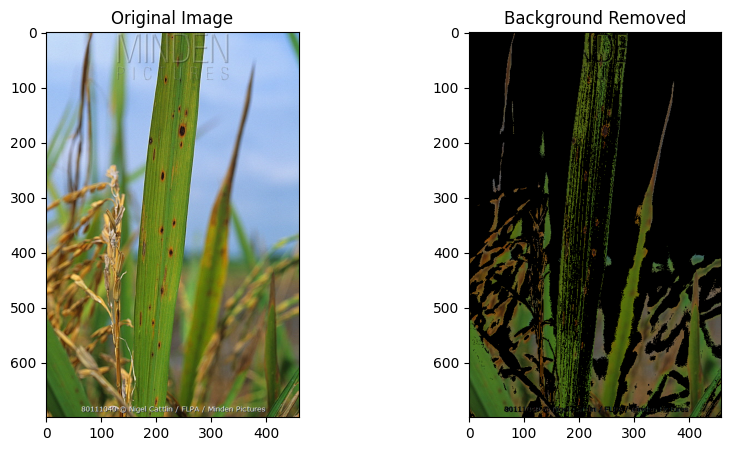

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# โหลดภาพ
img_path = 'bn2.jpg'
img = cv2.imread(img_path)

# แปลงภาพเป็นสีเทา
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ใช้การ Thresholding เพื่อสร้างมาสก์
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

# ปรับมาสก์เพื่อเอาพื้นหลังออก
mask = cv2.bitwise_not(thresh)
result = cv2.bitwise_and(img, img, mask=mask)

# แสดงผลลัพธ์
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Background Removed')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()